# LiDAR Scanner Georeferencing
## Introduction
The purpose of this notebook is to georeference a **LiDAR** cloud point taken by a FARO scanner. The method used is to directly georeference each point using a GPS collecting points coordinates of each LiDAR profile. 

The process is broken down in 2 steps:
1. We first go from the scanner reference system to GPS reference system
2. Then we go from GPS system to cartographic system

For this, we have 10 files containing data collected by the scanner. We also have the GPS file, which contains data collected by GPS while scanning.

![alt text](images/overview.jpeg)


In [3]:
import os
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This following a utility function to draw a 3D scatter using Matplotlib library

In [32]:
def plot(data: dict, elevation=None, azimuth=None):
    """
        Utility function to draw 3D scatter plot
    """
    fig = plt.figure(figsize=(10, 10)).gca(projection="3d")
    
    fig.scatter(data["x"], data["y"], data["z"], c=data["z"], cmap="rainbow")
    fig.set_title("3D plot")
    fig.set_xlabel('x-axis')
    fig.set_ylabel('y-axis')
    fig.set_zlabel('z-axis')
    fig.view_init(elevation, azimuth)
    plt.show()

## Data loading

We load the 10 scanner files as numpy arrays in a list, and we load GSP file as a numpy file

In [5]:
data_dir = "data/"

gps_file = "export_dgps_event2.txt"
gps = np.loadtxt(gps_file, skiprows=1)

data = list()

for filename in os.listdir(data_dir):
    file = os.path.join(data_dir, filename)
    data.append(np.loadtxt(file))

## Data exploration
Scanner data is divided in 10 files, each file contains a portion of the cloud point. The points are ordere by line of scanning instead of profile of scanning. Line ids are set between each file, which makes them redundant.

## Preprocessing
The following preprocessing will be applied on the scanner data

1. Change line indices to make them unique
2. Merge the 10 files in a single Numpy array
3. Reorder data by profile id instead of line id

### Changing line numbers:
We skip the first file, and then we add a variable number
to the line number on each of the remaining file.
This will make line numbers unique and avoid merging problems.

In [6]:
for i in range(len(data)):
    data[i][:, 0] = data[i][:, 0] + (i * 538)

### Merging data

We merge the 10 files in one single Numpy array

In [7]:
merged = data[0]
for file_input in data[1:]:
    merged = np.concatenate((merged, file_input))

### Sorting
We sort data by profile id then by line id

In [8]:
merged = merged[np.lexsort((merged[:,0], merged[:,1]))]

# We keep only 4 columns: (profile, X, Y, Z)

merged = merged[:, 1:5]

### Plot

We plot our initial data

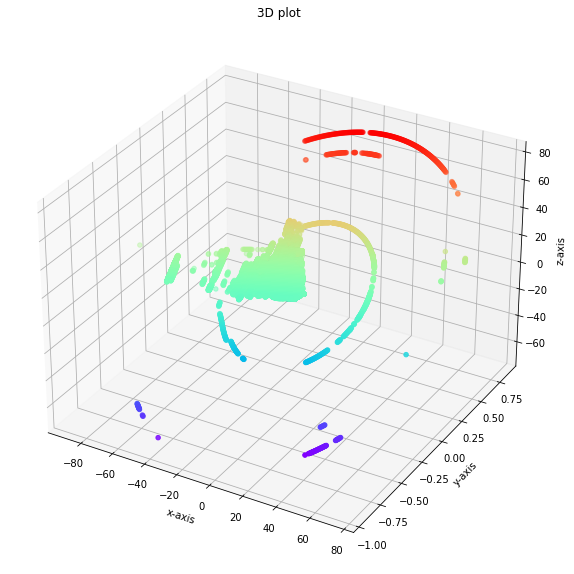

In [34]:
plot(data={
    "x": merged[: ,1],
    "y": merged[:, 2],
    "z": merged[:, 3],
})

## From Scanner to GPS
As a first step, we will transform our scanner coordinates to the GPS coordinates,

We will use this rotation matrix, provided by GPS
$$ 
M=\begin{pmatrix}
0 & 1 & 0\\
-1 & 0 & 0\\
0 & 0 & 1\\
\end{pmatrix}
$$

and for translation we will apply the vector
$$
v=\begin{bmatrix}
0 & 1 & 0\\
\end{bmatrix}
$$

In [36]:
translation_vector = np.array([0.14, 0.249, -0.076])
rotation_matrix = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

We iterate over our data and apply our transformations

In [37]:
result = np.empty((merged.shape[0], 4))
for i in range(merged.shape[0]):
    result[i] = np.array([merged[i][0], *(rotation_matrix.dot(merged[i][1:]) + translation_vector)])

We plot the result of our first transformation

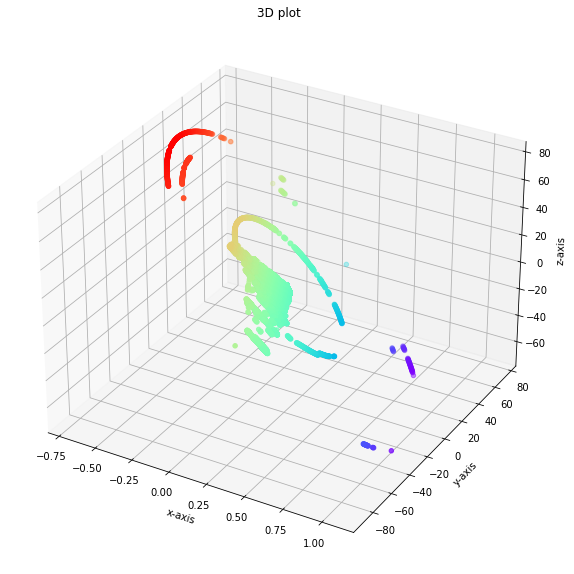

In [38]:
plot(data={
    "x": result[:,1],
    "y": result[:,2],
    "z": result[:,3],
})

## From GPS to Projection coordinates

The second transformation is to go from our calculated GPS coordinates to the projection coordinates,

The rotation matrix is defined as follows:

![alt text](images/rot_matrix.jpeg)

where $$\alpha, \beta, \gamma$$ represents the yaw, pitch

In [13]:
def gps_rotation_matrix(heading, pitch, roll):
    Rheading = np.array([
        [m.cos(heading), -m.sin(heading), 0],
        [m.sin(heading), m.cos(heading), 0],
        [0, 0, 1]
    ])
    
    Rpitch = np.array([
        [m.cos(pitch), 0, m.sin(pitch)],
        [0, 1, 0],
        [-m.sin(pitch), 0, m.cos(pitch)],
    ])
    
    Rroll = np.array([
        [1, 0, 0],
        [0, m.cos(roll), -m.sin(roll)],
        [0, m.sin(roll), m.cos(roll)],
    ])

    return Rheading * Rpitch * Rroll

In [14]:
gps_rotation_matrix(0.586, 22.061215, 0.495261).dot(result[0][1:]) + np.array([408805.808657, 5381737.416481, 190.215839])

array([4.08806268e+05, 5.38173996e+06, 1.31571678e+02])

In [15]:
result.shape

(1981443, 4)

In [16]:
print(np.where(result[:,0] == 499))

(array([1978949, 1978950, 1978951, ..., 1981440, 1981441, 1981442]),)


In [17]:
result[result[:,0] == 0, :]

array([[ 0.    , -0.5525,  3.4631, 66.8168],
       [ 0.    , -0.5537,  3.7992, 66.8007],
       [ 0.    , -0.5549,  4.1352, 66.7816],
       ...,
       [ 0.    ,  0.1417,  0.3481, -0.2552],
       [ 0.    ,  0.1416,  0.3348, -0.2428],
       [ 0.    ,  0.1417,  0.3377, -0.2505]])

In [18]:
gps[:,1:4]

array([[4.08805809e+05, 5.38173742e+06, 1.90215839e+02],
       [4.08805821e+05, 5.38173745e+06, 1.90215981e+02],
       [4.08805833e+05, 5.38173748e+06, 1.90216144e+02],
       ...,
       [4.08803459e+05, 5.38173612e+06, 1.90233266e+02],
       [4.08803476e+05, 5.38173611e+06, 1.90233453e+02],
       [4.08803938e+05, 5.38173594e+06, 1.90232538e+02]])

In [19]:
gps_result = np.empty((result.shape[0], 4))
counter = 0

for i in range(500):
    angles = np.array(gps[i, 7:10])
    gps_coordinates = np.array(gps[i, 1:4])
    rotation_matrix = gps_rotation_matrix(heading=angles[2], pitch=angles[1], roll=angles[0])
    
    results_by_profile = result[result[:,0] == i, :][:,1:]
    
    for j in range(results_by_profile.shape[0]):
        gps_result[counter] = np.array([0, *(results_by_profile[j].dot(rotation_matrix) + gps_coordinates)])
        counter += 1    

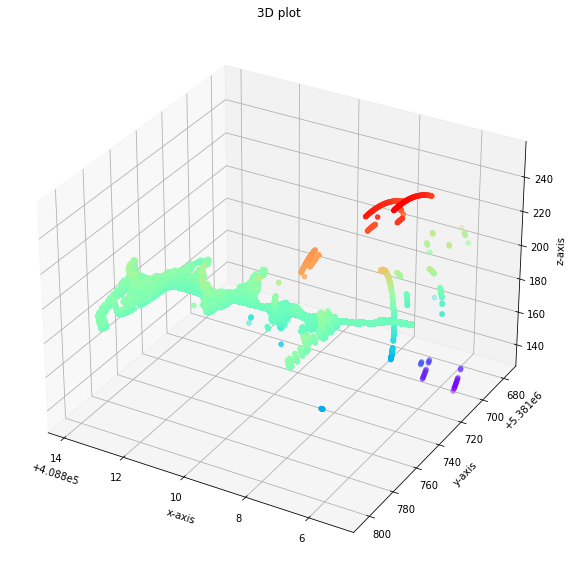

In [33]:
to_plot = gps_result
plot(data={
    "x": to_plot[:,1],
    "y": to_plot[:,2],
    "z": to_plot[:,3],
}, elevation=None, azimuth=120)